
# **Principi prezentacije i prepoznavanja oblika 2024/2025**
**Natalija Marinković IT66-2021**


**Tema projekta:** Detekcija godina, pola i emocija
<br><br> <br> <br>



## 1. Uvod
Zadatak ovog projekta je razvoj sistema koji na osnovu jedne slike lica istovremeno predviđa tri atributa: **starost**, **pol** i **emociju**. Ideja je da se kroz praktičan primer prikaže primena tehnika mašinskog učenja i prepoznavanja oblika na realnim podacima.

Problem se rešava korišćenjem konvolucione neuronske mreže (CNN) uz transfer learning i multi-task pristup. Jedan zajednički model prima sliku i iz nje izvlači osobine, dok se kroz tri odvojena izlaza predviđaju starost, pol i emocija. Na taj način sve tri predikcije koriste iste vizuelne informacije, što model čini kompaktnim i efikasnim.



## 2. Teorijska osnova

### 2.1 Konvolucione neuronske mreže (CNN)
CNN modeli su standard za obradu slika jer automatski uče različite nivoe vizuelnih osobina. Prvi slojevi prepoznaju jednostavnije šare (ivice, teksture), dok dublji slojevi prepoznaju složenije delove lica. Ova sposobnost ih čini veoma pogodnim za detekciju atributa kao što su starost, pol i emocija.

### 2.2 Transfer learning
Umesto da model treniramo od početka, koristi se unapred trenirani backbone **MobileNetV2**. Ovaj model je već naučen da prepoznaje razne vizuelne strukture, pa se u ovom projektu koristi kao osnova kojoj se dodaju nove izlazne grane. Time se značajno skraćuje vreme treniranja i poboljšava stabilnost.

### 2.3 Multi-task učenje
Multi-task učenje omogućava jednom modelu da rešava više zadataka tako što deli zajednički deo mreže, dok svaki zadatak ima posebnu izlaznu glavu. U ovom radu:
- starost se predviđa kao **regresija**,
- pol kao **binarna klasifikacija**,
- emocije kao **višeklasna klasifikacija**.

Pošto su ova tri zadatka povezana sa istim ulaznim podacima (slika lica), multi-task pristup je prirodan izbor.


## 3. Datasetovi korišćeni u projektu

### 3.1 Glavni dataset – IMDB-WIKI
Glavni skup podataka je **IMDB-WIKI (wiki_crop)**. Za svaku sliku dostupni su:
- godina rođenja,
- godina kada je fotografija snimljena,
- pol.

Starost se izračunava jednostavno kao:

\[
age = photo\_taken - birth\_year
\]

Kako bi podaci bili pouzdani, primenjene su sledeće provere i filtriranja:
- uklanjanje zapisa bez informacija o polu,
- izbacivanje loših detekcija lica (`face_score = -inf`),
- zadržavanje realnih starosti (0–100),
- provera da li fajlovi postoje na disku.

Ovaj skup predstavlja bazu modela i koristi se za sva učenja starosti i pola.









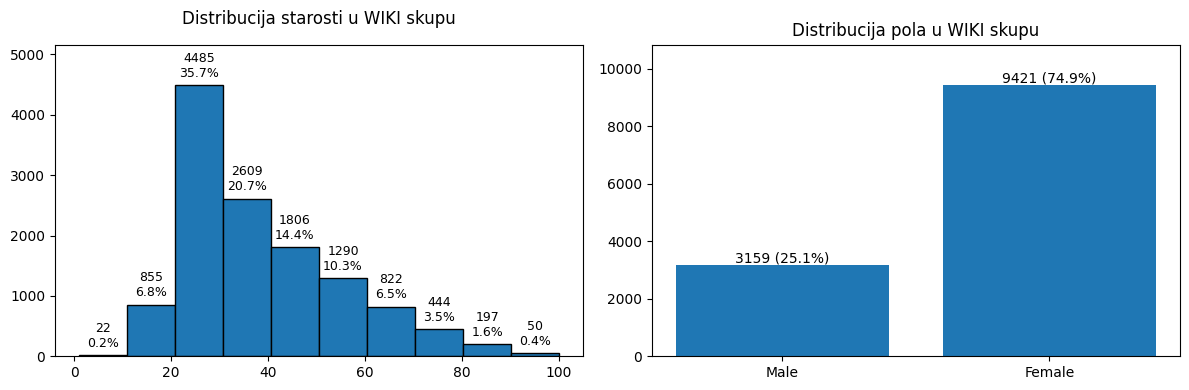

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,4))


plt.subplot(1, 2, 1)

counts, bins, _ = plt.hist(
    df["age"],
    bins=10,
    edgecolor="black"
)

total = len(df)
y_max = max(counts)

plt.title("Distribucija starosti u WIKI skupu", pad=15)
for count, left, right in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        percent = (count / total) * 100
        x = (left + right) / 2

        plt.text(
            x,
            count + 0.02 * y_max,
            f"{int(count)}\n{percent:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.ylim(0, y_max * 1.15)
plt.subplot(1, 2, 2)

gender_counts = df["gender"].value_counts().sort_index()
labels = ["Male", "Female"]
values = gender_counts.values
percentages = values / values.sum() * 100

bars = plt.bar(labels, values)
plt.title("Distribucija pola u WIKI skupu")
for i, (v, p) in enumerate(zip(values, percentages)):
    plt.text(
        i, v,
        f"{v} ({p:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.ylim(0, max(values) * 1.15)
plt.tight_layout()
plt.show()


### 3.2 Dataset za emocije – FER2013
Za emocije je korišćen FER2013, standardni dataset za prepoznavanje emocionalnih stanja na osnovu slike lica. On sadrži 7 klasa:
**angry, disgust, fear, happy, sad, surprise, neutral**.

Ovaj dataset ne sadrži informacije o starosti i polu, ali omogućava da se emocije kvalitetno nauče.





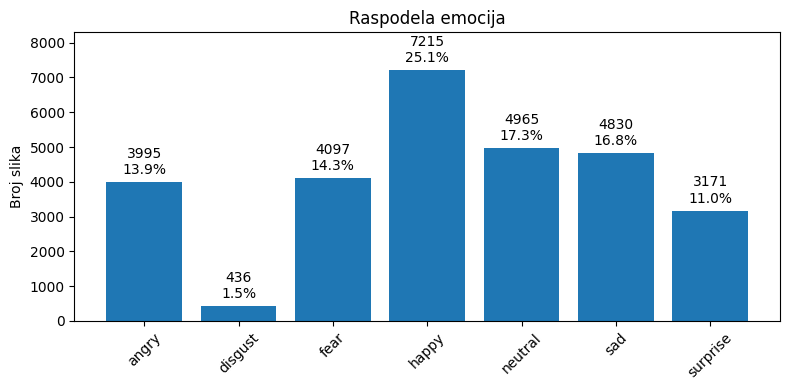

In [ ]:
import matplotlib.pyplot as plt


counts = {name: 0 for name in emotion_class_names}
for _, labels in emotion_train_ds:
    for l in labels.numpy():
        counts[emotion_class_names[int(l)]] += 1

labels = list(counts.keys())
values = list(counts.values())
total = sum(values)

plt.figure(figsize=(8,4))
bars = plt.bar(labels, values)

plt.title("Raspodela emocija")
plt.ylabel("Broj slika")
plt.xticks(rotation=45)

for i, v in enumerate(values):
    percent = (v / total) * 100
    plt.text(
        i,
        v + 0.02 * max(values),
        f"{v}\n{percent:.1f}%",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.ylim(0, max(values) * 1.15)
plt.tight_layout()
plt.show()




### 3.3 Povezivanje setova i pseudo-labeling emocija
IMDB-WIKI dataset nema emocije, a potrebna su sva tri izlaza za finalni multi-task model.  
Zato je primenjena trostepena procedura:

1. **Prva faza:** model se trenira za starost i pol na IMDB-WIKI skupu (emocije se ignorišu).
2. **Druga faza:** model se trenira samo za emocije na FER2013 skupu (starost i pol se ignorišu).
3. **Pseudo-labeling:** naučeni emotion model se koristi da automatski dodeli emociju svakoj slici u IMDB-WIKI skupu.
4. **Finalna faza:** sada kada glavni dataset ima:
   - starost  
   - pol  
   - emociju (pseudo-label)  
   model se zajedno trenira za sva tri zadatka.

Ovim postupkom zadovoljen je zahtev da finalni model radi sva tri predviđanja na istom glavnom skupu slika.






## 4. Uvoz biblioteka i podešavanje okruženja

U ovom delu uvoze se sve biblioteke koje će biti korišćene u daljem toku projekta. Biblioteke kao što su **os**, **glob** i **zipfile** koriste se za rad sa fajlovima i direktorijumima, dok **NumPy** i **Pandas** služe za numeričke proračune i obradu podataka. Za vizuelizaciju rezultata koristi se **matplotlib**.

Za izgradnju i treniranje modela neuronske mreže koristi se **TensorFlow/Keras**, a u okviru njega uvozi se i pretrenirani model **MobileNetV2** koji će kasnije biti iskorišćen kao osnova u procesu detekcije. Biblioteka **scikit-learn** obezbeđuje funkcionalnosti za podelu dataseta, dok se **scipy.io** koristi za učitavanje podataka u MAT formatu.

Takođe postavljamo **seed** vrednosti kako bi rezultati bili što ponovljiviji (da se pri svakom pokretanju dobiju približno isti rezultati).


In [2]:
import os, glob, random, zipfile, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
import scipy.io

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


## 5. Povezivanje Google Drive-a i definisanje putanja

Pošto se datasetovi nalaze na Google Drive-u, potrebno je da ga mountujemo kako bi Colab mogao da pristupi fajlovima.

Nakon toga definišemo osnovne putanje:
- `BASE_PATH` – glavni folder projekta na Drive-u  
- `WIKI_PATH` – folder gde se nalazi IMDB-WIKI (wiki_crop) dataset  
- `MAT_PATH` – .mat fajl sa metapodacima (dob, pol, godina slike itd.)

Ove putanje će se koristiti kasnije prilikom učitavanja podataka.


In [3]:

from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive/PPO"
WIKI_PATH = os.path.join(BASE_PATH, "IMDB & Wiki", "wiki_crop")
MAT_PATH  = os.path.join(WIKI_PATH, "wiki.mat")

print("WIKI_PATH:", WIKI_PATH)
print("MAT_PATH:", MAT_PATH)


Mounted at /content/drive
WIKI_PATH: /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_crop
MAT_PATH: /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_crop/wiki.mat


# Učitavanje već istreniranog modela

## 6. Učitavanje FER2013 dataset-a

FER2013 dataset se nalazi u ZIP arhivi na Google Drive-u.  
Prvo proveravamo da li je već otpakovan, a ako nije, raspakujemo ga u definisani folder.

FER2013 ima tipičnu strukturu:

- `train/` → slike za treniranje emocija  
- `test/` → slike za testiranje emocija  
- unutar svakog foldera nalaze se podfolderi po klasama emocija

Nakon otpakivanja dataset učitavamo putem `tf.keras.utils.image_dataset_from_directory()`.  
Ovaj metod automatski:
- čitа slike,
- skalira ih na zadatu dimenziju,
- pravi batcheve,
- kreira integer labele na osnovu naziva foldera.

Za emocije ćemo koristiti originalnih 7 klasa iz FER2013.


In [ ]:

FER_ZIP_PATH = "/content/drive/MyDrive/PPO/archive.zip"
EXTRACT_PATH = "/content/drive/MyDrive/PPO/emotions/fer2013"

if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH, exist_ok=True)
    with zipfile.ZipFile(FER_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)

print("FER folder:", EXTRACT_PATH)
print("Sadržaj:", os.listdir(EXTRACT_PATH))


FER folder: /content/drive/MyDrive/PPO/emotions/fer2013
Sadržaj: ['test', 'train']


### 6.1. Kreiranje FER2013 trening i test skupova

Definišu se putanje do `train` i `test` direktorijuma, nakon čega se dataset učitava pomoću funkcije **image_dataset_from_directory()**. Ovaj metod automatski učitava slike iz odgovarajućih foldera, konvertuje ih u tenzore i organizuje u batch-eve spremne za treniranje.

Dimenzije slika se uniformno postavljaju na **160×160 px**, isto kao i kod WIKI dataset-a, kako bi se obezbedio jedinstven oblik ulaza za sve zadatke u okviru modela (detekcija pola, godina i emocija).


In [ ]:

FER_TRAIN_DIR = os.path.join(EXTRACT_PATH, "train")
FER_TEST_DIR  = os.path.join(EXTRACT_PATH, "test")

IMG_SIZE = (160, 160)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

emotion_train_ds = tf.keras.utils.image_dataset_from_directory(
    FER_TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="rgb"
)

emotion_test_ds = tf.keras.utils.image_dataset_from_directory(
    FER_TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    color_mode="rgb",
    shuffle=False
)

emotion_class_names = emotion_train_ds.class_names
print("Emocije (redosled):", emotion_class_names)

emotion_train_ds = emotion_train_ds.prefetch(AUTOTUNE)
emotion_test_ds  = emotion_test_ds.prefetch(AUTOTUNE)


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Emocije (redosled): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


FER dataset je sada spreman za upotrebu.  
Ovaj skup ćemo kasnije koristiti u **Fazi B**, gde model uči samo emocije.




## 7. Učitavanje i obrada IMDB-WIKI dataset-a (starost i pol)

U ovom delu učitava se **IMDB-WIKI dataset**, koji sadrži slike lica zajedno sa pripadajućim metapodacima. Podaci o svakoj slici nalaze se u fajlu `wiki.mat`, iz kog se izdvajaju sledeći elementi:
- `full_path` – putanja do slike unutar dataset-a
- `dob` – datum rođenja u MATLAB formatu
- `photo_taken` – godina u kojoj je fotografija nastala
- `gender` – oznaka pola
- `face_score` i `second_face_score` – parametri kvaliteta detekcije lica

Pošto MATLAB koristi specifičan način zapisivanja datuma, neophodna je konverzija vrednosti `dob` u standardnu godinu rođenja. Nakon toga se starost osobe na slici izračunava oduzimanjem godine rođenja od godine kada je fotografija nastala.

Na kraju se formira DataFrame koji sadrži sve ključne informacije potrebne za dalju obradu: putanju do slike, starost, pol i ocenu kvaliteta detektovanog lica.


In [5]:
import scipy.io

mat = scipy.io.loadmat(MAT_PATH)
wiki = mat["wiki"][0,0]

full_path   = wiki["full_path"][0]
dob         = wiki["dob"][0]
photo_taken = wiki["photo_taken"][0]
gender      = wiki["gender"][0]
face_score  = wiki["face_score"][0]
second_face = wiki["second_face_score"][0]

def matlab_datenum_to_year(dn):
    try:
        dn = float(dn)
        if np.isnan(dn):
            return np.nan
        ordinal = int(dn)
        frac = dn - ordinal
        dt = datetime.datetime.fromordinal(ordinal) \
             + datetime.timedelta(days=frac) \
             - datetime.timedelta(days=366)
        return dt.year
    except:
        return np.nan

birth_year = np.array([matlab_datenum_to_year(d) for d in dob])
ages = photo_taken - birth_year

df = pd.DataFrame({
    "file": [os.path.join(WIKI_PATH, p[0]) for p in full_path],
    "age": ages,
    "gender": gender,
    "face_score": face_score,
    "second_face_score": second_face
})

print(df.head())


                                                file  age  gender  face_score  \
0  /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_cr...   28     1.0    4.300962   
1  /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_cr...   39     1.0    2.645639   
2  /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_cr...   60     1.0    4.329329   
3  /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_cr...   31     1.0        -inf   
4  /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_cr...   41     0.0    3.408442   

   second_face_score  
0                NaN  
1           1.949248  
2                NaN  
3                NaN  
4                NaN  


### 7.1 Čišćenje podataka

IMDB-WIKI dataset je veliki i sadrži i loše uzorke, pa je potrebno čišćenje:
- izbacujemo slike bez informacije o polu
- uklanjamo slike gde je detekcija lica loša (`face_score = -inf`)
- zadržavamo samo realne starosti (0–100 godina)
- pol pretvaramo u integer (0 ili 1)

Nakon ovoga dobijamo pouzdan skup za trening.


In [6]:
print("Pre čišćenja:", len(df))

df = df[df["gender"].notna()]
df = df[df["face_score"] != -np.inf]
df = df[(df["age"] >= 0) & (df["age"] <= 100)]
df["gender"] = df["gender"].astype(int)

print("Posle čišćenja:", len(df))
print("Age min/max:", df["age"].min(), df["age"].max())
print("Gender distribucija:\n", df["gender"].value_counts())


Pre čišćenja: 62328
Posle čišćenja: 43390
Age min/max: 0 100
Gender distribucija:
 gender
1    32607
0    10783
Name: count, dtype: int64


### 7.2 Provera da li slike postoje

Dešava se da u `.mat` fajlu postoje putanje za slike koje nisu stvarno dostupne u folderu.  
Zato proveravamo postojanje fajlova i zadržavamo samo one koji postoje.


In [ ]:
exists_mask = df["file"].apply(os.path.exists)
df = df[exists_mask].reset_index(drop=True)

print("Posle provere fajlova:", len(df))


Posle provere fajlova: 12580


## 8. Podela IMDB-WIKI skupa na trening i test deo

Nakon čišćenja, glavni IMDB-WIKI skup delimo na trening i test podskup.  
Koristimo `train_test_split` iz scikit-learn biblioteke, gde uzimamo 80% podataka za treniranje i 20% za testiranje.

Ova podela se radi nasumično, ali uz fiksiran `random_state` da bi rezultati bili ponovljivi.


In [7]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train:", len(train_df))
print("Test:", len(test_df))


Train: 34712
Test: 8678


## 9. Kreiranje `tf.data` pipeline-a za IMDB-WIKI

Da bi trening bio efikasan, slike se ne učitavaju sve odjednom u memoriju, već se koristi `tf.data` pipeline.  
Pravimo funkciju koja:
1. učita sliku sa diska,
2. dekodira je kao RGB,
3. skaluje na 160×160,
4. normalizuje na opseg [0,1],
5. vraća sliku i odgovarajuće labele (age, gender).

Zatim pravimo posebne train i test dataset objekte.


In [ ]:
def load_wiki_image(path, age, gender):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, {"age": age, "gender": gender}

def make_wiki_dataset(df_subset, shuffle=True):
    paths = df_subset["file"].values
    ages  = df_subset["age"].values.astype(np.float32)
    gend  = df_subset["gender"].values.astype(np.float32)

    ds = tf.data.Dataset.from_tensor_slices((paths, ages, gend))
    if shuffle:
        ds = ds.shuffle(len(df_subset))
    ds = ds.map(load_wiki_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_wiki_dataset(train_df, shuffle=True)
test_ds  = make_wiki_dataset(test_df, shuffle=False)

print("WIKI dataset spreman!")


WIKI dataset spreman!


## 10. Dodavanje “dummy” emocija za Fazu A

U ovom trenutku IMDB-WIKI skup ima samo starost i pol.  
Pošto model kasnije ima i emotion izlaz, a u **Fazi A** treniramo samo starost i pol, dodajemo privremenu emociju kao nulu.

To radimo tako što na svaki batch dodamo novu labelu `"emotion"` koja je vektor nula.




In [ ]:
def add_dummy_emotion(img, labels):
    bs = tf.shape(labels["age"])[0]
    new_labels = {
        "age": labels["age"],
        "gender": labels["gender"],
        "emotion": tf.zeros((bs,), dtype=tf.int32)
    }
    return img, new_labels

train_ds = train_ds.map(add_dummy_emotion)
test_ds  = test_ds.map(add_dummy_emotion)


Glavni dataset je sada spreman za **Fazu A** treninga, gde model uči starost i pol na IMDB-WIKI slikama.

Sledeći korak je definisanje augmentacija (blage transformacije slika) i izgradnja multi-task modela.


## 11. Augmentacije podataka

Pre izgradnje modela dodajemo augmentacije kako bismo povećali raznovrsnost podataka tokom treninga.  
Augmentacije pomažu modelu da bolje generalizuje jer vidi slike u malo različitim varijantama (npr. blago rotirane ili horizontalno okrenute).

Koristimo jednostavne i realne augmentacije:
- horizontalni flip (lice levo/desno)
- mala rotacija
- blagi zoom




Dataset IMDB-WIKI ima dosta varijacija, ali i dalje postoji rizik da model “napamti” određena lica.
U praksi slike lica mogu biti blago rotirane, okrenute levo/desno ili različito uvećane, pa augmentacije pomažu da model to nauči.

In [8]:
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augmentation")



## 12. Izgradnja multi-task modela sa tri izlaza

U ovom koraku formira se kompletan neuronski model koji istovremeno rešava tri zadatka: procenu starosti, određivanje pola i klasifikaciju emocija.
Za zajedničku osnovu koristi se MobileNetV2, popularna i efikasna konvolutivna mreža trenirana na ImageNet skupu, koja služi kao feature extractor.

Model se sastoji iz:
1. **Ulaz i augmentacije** - Ulazna slika prolazi kroz blok za augmentacije kako bi model tokom treninga viđao što raznovrsnije primere.
2. **Backbone-a (MobileNetV2)** koji izvlači zajedničke osobine iz slike
3. **Zajednički embedding** - Nakon MobileNet-a primenjuje se GlobalAveragePooling2D koji pretvara prostorne mape u jedan vektor
4. **Tri izlaza:**
   - Age head → regresija (1 neuron, linearni izlaz)
   - Gender head → binarna klasifikacija (1 neuron, sigmoid)
   - Emotion head → višeklasna klasifikacija (7 neurona, softmax)

Backbone je u početku zamrznut (`trainable = False`) kako bismo prvo istrenirali head-ove stabilno,  
a kasnije ćemo ga odmrznuti u finalnoj fazi fine-tuning-a.





U model smo dodali **Dropout sloj** sa vrednošću 0.2 kako bismo smanjili mogućnost pretreniranosti (overfitting-a).  
Dropout tokom treninga nasumično “gasi” deo neurona, zbog čega mreža ne može da se osloni samo na mali broj osobina, već mora da uči stabilnije i opštije karakteristike.

In [9]:
IMG_SIZE = (160, 160)

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = data_aug(inputs)
backbone = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3)
)

x = backbone(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
age_x = layers.Dense(128, activation="relu")(x)
age_out = layers.Dense(1, name="age")(age_x)
gen_x = layers.Dense(64, activation="relu")(x)
gender_out = layers.Dense(1, activation="sigmoid", name="gender")(gen_x)
emo_x = layers.Dense(128, activation="relu")(x)
emotion_out = layers.Dense(7, activation="softmax", name="emotion")(emo_x)

model = keras.Model(inputs=inputs, outputs=[age_out, gender_out, emotion_out])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 160, 160,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_1… │ (None, 5, 5,      │  2,257,984 │ augmentation[0][… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,968 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     81,984 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    163,968 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 1)         │        129 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 1)         │         65 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion (Dense)     │ (None, 7)         │        903 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,669,001 (10.18 MB)

 Trainable params: 2,634,889 (10.05 MB)

 Non-trainable params: 34,112 (133.25 KB)

Model je sada definisan i spreman za treniranje.

## 13. Callback funkcije za trening

Pre treninga definišemo callback-e koji pomažu da trening bude stabilniji i da se automatski zaustavi kada nema napretka.

Koristimo:
- **EarlyStopping**: prekida trening ako se validaciona greška ne poboljšava nekoliko epoha. Opcija `restore_best_weights=True` obezbeđuje da se nakon zaustavljanja učitaju najbolje težine postignute tokom treninga.
- **ReduceLROnPlateau**: smanjuje learning rate ako model “zapne”. Smanjenje stope učenja `factor=0.5` daje mreži mogućnost da pronađe finije, stabilnije rešenje u kasnijim fazama treniranja.
- **ModelCheckpoint**: čuva najbolji model tokom treninga.




In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5),
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
]


## 14. Kompajliranje modela za Fazu A (starost + pol)

U prvoj fazi treniramo samo **starost i pol** na glavnom IMDB-WIKI skupu.  
Emocije u ovoj fazi ne učestvuju u optimizaciji, zato im postavljamo težinu gubitka na 0.

Loss funkcije:
- **age** → MAE (regresija)
- **gender** → binary cross-entropy
- **emotion** → sparse categorical cross-entropy (ali sa weight=0 u ovoj fazi)




U projektu se koristi
**Adam optimizer** jer se u praksi pokazao kao jedan od najstabilnijih i najbržih za treniranje dubokih neuronskih mreža.  
Adam automatski prilagođava korak učenja (learning rate) za svaki parametar posebno, što je korisno kada imamo složen CNN model i više izlaza (starost, pol i emocije).  
Zbog toga model brže dolazi do boljih rezultata i manje “osciluje”.
Kao learning rate koristimo vrednost `1e-4`, što je standardna i bezbedna vrednost za transfer learning faze.



In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss={
        "age": "mae",
        "gender": "binary_crossentropy",
        "emotion": "sparse_categorical_crossentropy"
    },
    metrics={
        "age": [tf.keras.metrics.MeanAbsoluteError(name="mae")],
        "gender": [tf.keras.metrics.BinaryAccuracy(name="accuracy")],
        "emotion": [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    },
    loss_weights={"age": 1.0, "gender": 1.0, "emotion": 0.0}
)


## 15. Faza A trening na IMDB-WIKI skupu

Treniramo model na WIKI train skupu, a validaciju radimo na WIKI test skupu.  
Tokom ove faze model uči osobine lica koje su bitne za starost i pol.


In [ ]:
history_wiki = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    callbacks=callbacks
)


Epoch 1/3
315/315 ━━━━━━━━━━━━━━━━━━━━ 1531s 5s/step - age_loss: 20.4912 - age_mae: 20.4913 - emotion_accuracy: 0.0738 - emotion_loss: 2.5839 - gender_accuracy: 0.7807 - gender_loss: 0.4964 - loss: 20.9877 - val_age_loss: 11.8232 - val_age_mae: 11.8183 - val_emotion_accuracy: 0.0727 - val_emotion_loss: 2.3983 - val_gender_accuracy: 0.8680 - val_gender_loss: 0.3207 - val_loss: 12.1387 - learning_rate: 1.0000e-04
Epoch 2/3
315/315 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - age_loss: 11.6930 - age_mae: 11.6930 - emotion_accuracy: 0.0712 - emotion_loss: 2.5650 - gender_accuracy: 0.8667 - gender_loss: 0.3331 - loss: 12.0261 - val_age_loss: 10.9957 - val_age_mae: 10.9861 - val_emotion_accuracy: 0.0727 - val_emotion_loss: 2.3983 - val_gender_accuracy: 0.8772 - val_gender_loss: 0.3088 - val_loss: 11.2946 - learning_rate: 1.0000e-04
Epoch 3/3
315/315 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - age_loss: 11.1312 - age_mae: 11.1312 - emotion_accuracy: 0.0673 - emotion_loss: 2.6006 - gender_accuracy: 0.8732 - ge

In [ ]:
model.save("/content/drive/MyDrive/PPO/model_fazaA.keras")
print("Model Faza A sacuvan!")


Model Faza A sacuvan!


## 16. Prikaz rezultata treninga za Fazu A

Posmatramo:
- kretanje MAE za starost
- tačnost pola
- age loss

Ovo nam daje uvid da li model napreduje i kako se ponaša na validacionom skupu.


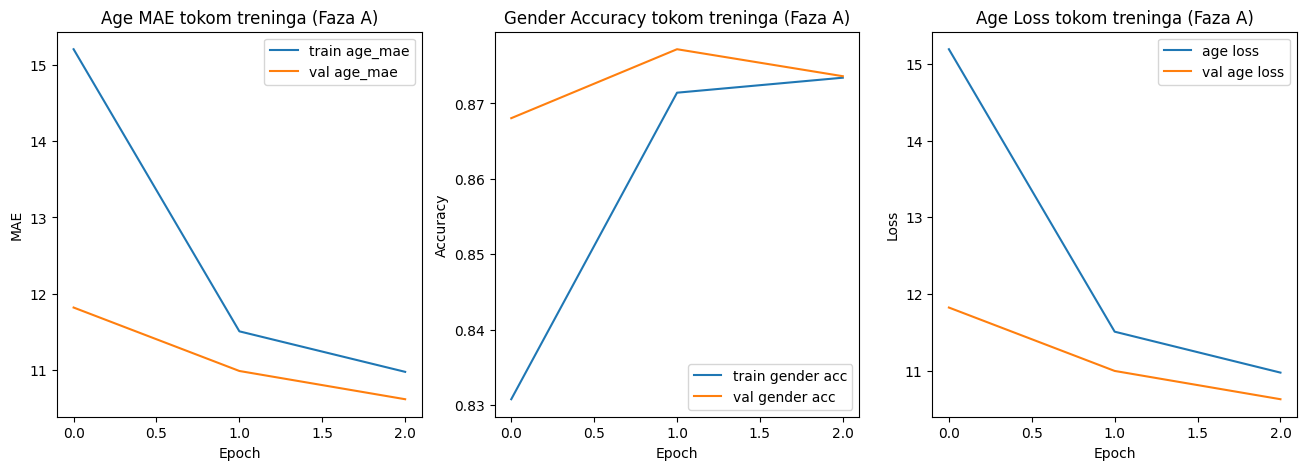

In [ ]:
h = history_wiki.history

plt.figure(figsize=(16,5))

# AGE MAE
plt.subplot(1,3,1)
plt.plot(h["age_mae"], label="train age_mae")
plt.plot(h["val_age_mae"], label="val age_mae")
plt.title("Age MAE tokom treninga (Faza A)")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

# GENDER accuracy
gender_key = None
for k in ["gender_accuracy", "gender_acc"]:
    if k in h:
        gender_key = k
        break

plt.subplot(1,3,2)
plt.plot(h[gender_key], label="train gender acc")
plt.plot(h["val_" + gender_key], label="val gender acc")
plt.title("Gender Accuracy tokom treninga (Faza A)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# AGE loss
plt.subplot(1,3,3)
plt.plot(h["age_loss"], label="age loss")
plt.plot(h["val_age_loss"], label="val age loss")
plt.title("Age Loss tokom treninga (Faza A)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


Faza A je završena. Model je sada naučio da odredi starost i pol na glavnom datasetu.

Sledeća faza je priprema FER2013 i trening emocija (Faza B).


## 17. Priprema FER2013 skupa za multi-task format

FER2013 dataset vraća slike i emotion labele u obliku `(imgs, label)`, dok naš multi-task model očekuje rečnik sa tri izlaza (`age`, `gender`, `emotion`).  
Zato pravimo map funkciju koja:
- emotion label prosleđuje kao pravi izlaz,
- age i gender postavlja na nule (jer se u ovoj fazi ne treniraju).

Na taj način FER2013 možemo direktno koristiti sa istim modelom.




In [ ]:

data_aug_fer = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


def map_emotion_to_multitask(imgs, emo_label):
    imgs = data_aug_fer(imgs, training=True)
    bs = tf.shape(emo_label)[0]
    labels = {
        "age": tf.zeros((bs, 1), dtype=tf.float32),
        "gender": tf.zeros((bs, 1), dtype=tf.float32),
        "emotion": tf.cast(emo_label, tf.int32)
    }
    return imgs, labels

emotion_train_ds_mh = emotion_train_ds.map(map_emotion_to_multitask).prefetch(AUTOTUNE)
emotion_test_ds_mh  = emotion_test_ds.map(map_emotion_to_multitask).prefetch(AUTOTUNE)

print("FER multi-head dataset spreman!")


FER multi-head dataset spreman!


In [ ]:

backbone.trainable = True
for layer in backbone.layers[:-30]:
    layer.trainable = False


## 18. Kompajliranje modela za Fazu B (emocije)

U ovoj fazi treniramo samo **emotion head** na FER2013 skupu.  
Age i gender ne učestvuju u loss-u, pa njihove težine postavljamo na 0.

Time backbone i emotion grana uče osobine lica koje odgovaraju emocionalnim ekspresijama.


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss={
        "age": "mae",
        "gender": "binary_crossentropy",
        "emotion": "sparse_categorical_crossentropy"
    },
    metrics={
        "age": [tf.keras.metrics.MeanAbsoluteError(name="mae")],
        "gender": [tf.keras.metrics.BinaryAccuracy(name="accuracy")],
        "emotion": [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    },
    loss_weights={"age": 0.0, "gender": 0.0, "emotion": 1.0}
)


## 19. Faza B trening na FER2013 skupu

Treniramo model na FER train skupu, a validaciju radimo na FER test skupu.  
Tokom ove faze model uči emocije nezavisno od starosti i pola.


In [ ]:
history_emotion = model.fit(
    emotion_train_ds_mh,
    validation_data=emotion_test_ds_mh,
    epochs=3,
    callbacks=callbacks

)


Epoch 1/3
898/898 ━━━━━━━━━━━━━━━━━━━━ 4173s 5s/step - age_loss: 16.5602 - age_mae: 16.5602 - emotion_accuracy: 0.2120 - emotion_loss: 1.9712 - gender_accuracy: 0.0598 - gender_loss: 1.3320 - loss: 1.9712 - val_age_loss: 13.5598 - val_age_mae: 13.5616 - val_emotion_accuracy: 0.2590 - val_emotion_loss: 1.8359 - val_gender_accuracy: 0.2226 - val_gender_loss: 0.9183 - val_loss: 1.8350 - learning_rate: 1.0000e-05
Epoch 2/3
898/898 ━━━━━━━━━━━━━━━━━━━━ 1298s 1s/step - age_loss: 14.2143 - age_mae: 14.2143 - emotion_accuracy: 0.3044 - emotion_loss: 1.7421 - gender_accuracy: 0.0509 - gender_loss: 1.2655 - loss: 1.7421 - val_age_loss: 14.0205 - val_age_mae: 14.0205 - val_emotion_accuracy: 0.3188 - val_emotion_loss: 1.7101 - val_gender_accuracy: 0.0791 - val_gender_loss: 1.1475 - val_loss: 1.7099 - learning_rate: 1.0000e-05
Epoch 3/3
898/898 ━━━━━━━━━━━━━━━━━━━━ 1291s 1s/step - age_loss: 13.4235 - age_mae: 13.4235 - emotion_accuracy: 0.3333 - emotion_loss: 1.6801 - gender_accuracy: 0.0509 - gend

## 20. Prikaz rezultata treninga za Fazu B

Pratimo:
- tačnost emocija (accuracy)
- emotion loss

Ovo nam govori koliko dobro model razlikuje emocije na FER2013 skupu.


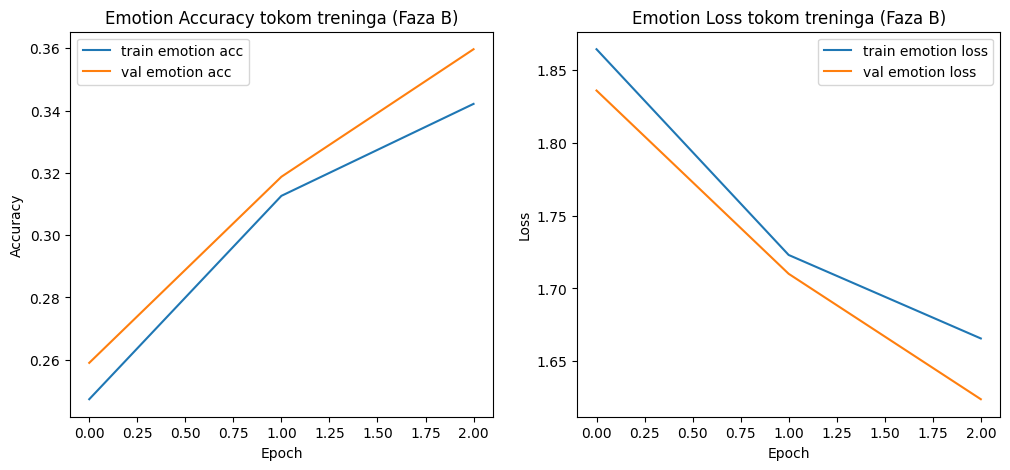

In [ ]:
h2 = history_emotion.history

plt.figure(figsize=(12,5))

# EMOTION accuracy
emotion_key = None
for k in ["emotion_accuracy", "emotion_acc"]:
    if k in h2:
        emotion_key = k
        break

plt.subplot(1,2,1)
plt.plot(h2[emotion_key], label="train emotion acc")
plt.plot(h2["val_" + emotion_key], label="val emotion acc")
plt.title("Emotion Accuracy tokom treninga (Faza B)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# EMOTION loss
plt.subplot(1,2,2)
plt.plot(h2["emotion_loss"], label="train emotion loss")
plt.plot(h2["val_emotion_loss"], label="val emotion loss")
plt.title("Emotion Loss tokom treninga (Faza B)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


## 21. Evaluacija emocija na FER test skupu

Merimo performanse emotion head-a na FER2013 test delu.


In [ ]:
results_fer = model.evaluate(emotion_test_ds_mh, verbose=1, return_dict=True)

print("FER test metrike:")
for k, v in results_fer.items():
    print(f"{k}: {v:.4f}")

print("Svi ključevi:", results_fer.keys())

print("\nFER emotion_accuracy:", results_fer.get("emotion_accuracy"))
print("FER emotion_loss:", results_fer.get("emotion_loss"))


225/225 ━━━━━━━━━━━━━━━━━━━━ 182s 802ms/step - age_loss: 14.1293 - age_mae: 14.1292 - emotion_accuracy: 0.2719 - emotion_loss: 1.7951 - gender_accuracy: 0.0470 - gender_loss: 1.2490 - loss: 1.7951
FER test metrike:
age_loss: 14.1648
age_mae: 14.1611
emotion_accuracy: 0.3564
emotion_loss: 1.6312
gender_accuracy: 0.0446
gender_loss: 1.2543
loss: 1.6330
Svi ključevi: dict_keys(['age_loss', 'age_mae', 'emotion_accuracy', 'emotion_loss', 'gender_accuracy', 'gender_loss', 'loss'])

FER emotion_accuracy: 0.35636666417121887
FER emotion_loss: 1.6311931610107422


## 22. Confusion matrix i classification report (FER2013)

Da bismo detaljnije videli gde model greši, pravimo confusion matrix i izveštaj po klasama.




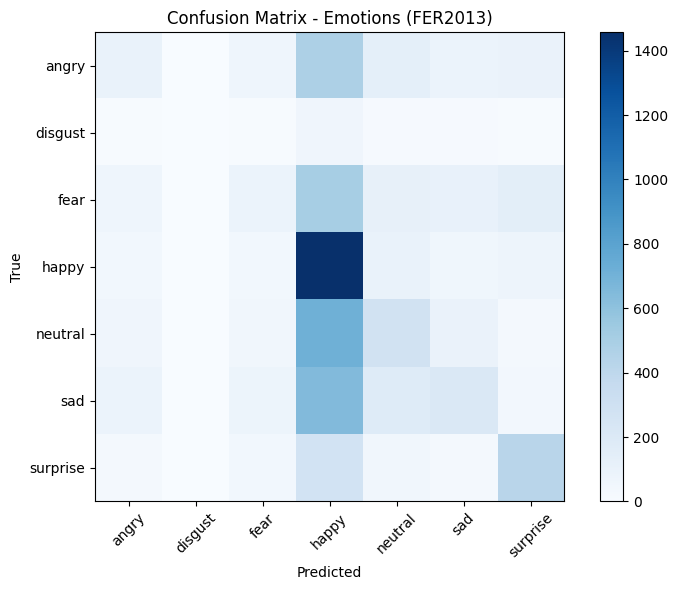

              precision    recall  f1-score   support

       angry       0.25      0.10      0.15       958
     disgust       0.00      0.00      0.00       111
        fear       0.24      0.09      0.13      1024
       happy       0.35      0.82      0.49      1774
     neutral       0.32      0.23      0.27      1233
         sad       0.36      0.17      0.23      1247
    surprise       0.52      0.51      0.52       831

    accuracy                           0.36      7178
   macro avg       0.29      0.27      0.25      7178
weighted avg       0.33      0.36      0.31      7178



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

emotion_names = emotion_class_names

y_true, y_pred = [], []
for imgs, labels in emotion_test_ds_mh:
    _, _, pred_emotion = model.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(pred_emotion, axis=1))
    y_true.extend(labels["emotion"].numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Emotions (FER2013)")
plt.colorbar()
plt.xticks(range(len(emotion_names)), emotion_names, rotation=45)
plt.yticks(range(len(emotion_names)), emotion_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print(classification_report(
    y_true, y_pred,
    target_names=emotion_names,
    zero_division=0
))


### Evaluacija emotion head-a na FER2013 test skupu
Na FER test skupu dobijena je ukupna tačnost oko **33%**, što je očekivano s obzirom na težinu skupa i nebalansiranost klasa.  

Najbolje rezultate model postiže za emociju **happy** (recall ≈ 0.73, F1 ≈ 0.50), jer je ta emocija vizuelno najprepoznatljivija i ima najviše uzoraka u skupu.  
Emocije **neutral, angry i sad** imaju srednje performanse (F1 oko 0.23–0.29), pri čemu se model često zbunjuje između sličnih izraza lica.  

Najslabiji rezultat je za emociju **disgust** (recall i precision 0), što je posledica veoma malog broja uzoraka u toj klasi.  
Kod emocije **surprise** primećuje se veći recall, ali nizak precision, što znači da model ponekad pogrešno predvidi surprise i kada nije prisutna.

Generalno, emotion head je naučio osnovne obrasce emocija, a ograničenja dolaze pre svega iz nebalansiranosti FER2013 skupa i sličnosti između pojedinih klasa.


Faza B je završena i model sada zna da prepoznaje emocije na FER2013 skupu.

Sledeći korak je **pseudo-labeling emocija na IMDB-WIKI glavnom skupu** i zatim finalni trening na tom istom skupu sa sve tri labele.


## 23. Pseudo-labeling emocija za IMDB-WIKI (glavni skup)

Do sada su emocije naučene isključivo na FER2013 skupu.  
Pošto glavni IMDB-WIKI skup nema emocije, emocije se predviđaju modelom naučenim na FER2013.
Model se koristi da **predvidi emociju za svaku sliku iz glavnog skupa**.

Ovaj proces se zove *pseudo-labeling*:
- model predvidi emociju za sliku,
- uzima se klasa sa najvećom verovatnoćom,
- ta emocija se upisuje kao nova labela u DataFrame.

Time dobijamo prošireni glavni skup koji sada ima:
- `age`
- `gender`
- `emotion` (pseudo-label iz modela)




In [ ]:
def predict_emotion_for_df(df_subset):
    paths = df_subset["file"].values
    emo_labels = []
    for i in range(0, len(paths), BATCH_SIZE):
        batch_paths = paths[i:i+BATCH_SIZE]
        batch_imgs = []
        for p in batch_paths:
            img = tf.io.read_file(p)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, IMG_SIZE)
            img = tf.cast(img, tf.float32) / 255.0
            batch_imgs.append(img)

        batch_imgs = tf.stack(batch_imgs)

        # predikcija emocija
        _, _, emo_probs = model.predict(batch_imgs, verbose=0)
        emo_pred = np.argmax(emo_probs, axis=1)
        emo_labels.extend(list(emo_pred))
    df_subset = df_subset.copy()
    df_subset["emotion"] = emo_labels
    return df_subset

train_df3 = predict_emotion_for_df(train_df)
test_df3  = predict_emotion_for_df(test_df)
print(train_df3.head())


                                                    file  age  gender  \
4816   /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_cr...   27       1   
10775  /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_cr...   38       0   
4913   /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_cr...   42       1   
10815  /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_cr...   47       1   
7814   /content/drive/MyDrive/PPO/IMDB & Wiki/wiki_cr...   54       0   

       face_score  second_face_score  emotion  
4816     2.355863                NaN        4  
10775    4.165127                NaN        5  
4913     2.742844                NaN        4  
10815    3.213195                NaN        5  
7814     4.626283                NaN        5  


Sada `train_df3` i `test_df3` predstavljaju glavni dataset sa sve tri labele.  
U sledećem segmentu pravimo novi `tf.data` pipeline koji vraća age, gender i emotion zajedno i radimo finalni multi-task trening na ovom glavnom skupu.


## 24. Kreiranje finalnog WIKI tf.data skupa sa sve tri labele (age, gender, emotion)

Sada kada smo pseudo-labelovanjem dobili emocije za ceo IMDB-WIKI skup, potrebno je da napravimo **novi tf.data pipeline** koji vraća sve tri labele u obliku koji multi-task model očekuje.

Koraci:
1. učitavanje slike,
2. normalizacija i resize,
3. formiranje rečnika sa `"age"`, `"gender"` i `"emotion"`.

Ovo je sada pravi dataset nad kojim ćemo trenirati finalni model.


In [ ]:
def load_wiki_image_full(path, age, gender, emotion):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    labels = {
        "age": age,
        "gender": gender,
        "emotion": emotion
    }
    return img, labels

def make_wiki_dataset_full(df_subset, shuffle=True):
    paths   = df_subset["file"].values
    ages    = df_subset["age"].values.astype(np.float32)
    genders = df_subset["gender"].values.astype(np.float32)
    emotions= df_subset["emotion"].values.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((paths, ages, genders, emotions))
    if shuffle:
        ds = ds.shuffle(len(df_subset))
    ds = ds.map(load_wiki_image_full, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds_full = make_wiki_dataset_full(train_df3, shuffle=True)
test_ds_full  = make_wiki_dataset_full(test_df3, shuffle=False)

print("Finalni WIKI dataset (age + gender + emotion) spreman!")


Finalni WIKI dataset (age + gender + emotion) spreman!


## 25. Finalno kompajliranje modela (sva tri izlaza aktivna)

U poslednjoj fazi model trenira:
- **AGE** → MAE
- **GENDER** → binary cross-entropy
- **EMOTION** → sparse categorical cross-entropy

Sve tri grane sada učestvuju u treningu, pa su sve težine = 1.


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss={
        "age": "mae",
        "gender": "binary_crossentropy",
        "emotion": "sparse_categorical_crossentropy"
    },
    metrics={
        "age": [tf.keras.metrics.MeanAbsoluteError(name="mae")],
        "gender": [tf.keras.metrics.BinaryAccuracy(name="accuracy")],
        "emotion": [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
    },
    loss_weights={"age": 1.0, "gender": 1.0, "emotion": 1.0}
)


## 26. Finalni multi-task trening na glavnom skupu

Treniramo model na IMDB-WIKI skupu sa svim labelama.  
Ova faza spaja znanje o starosti, polu i emocijama u jedan stabilan model.

Tokom ove faze modeli obično nauče:
- bolje globalne osobine lica (jer svi zadaci učestvuju),
- stabilnije predikcije emocija (zbog konteksta),
- bolju tačnost pola i starosti (zahvaljujući dodatnim signalima).


In [ ]:
history_final = model.fit(
    train_ds_full,
    validation_data=test_ds_full,
    epochs=3,
    callbacks=callbacks
)


Epoch 1/3
315/315 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - age_loss: 11.2747 - age_mae: 11.2746 - emotion_accuracy: 0.6520 - emotion_loss: 0.9884 - gender_accuracy: 0.8639 - gender_loss: 0.3392 - loss: 12.6023 - val_age_loss: 11.8071 - val_age_mae: 11.8115 - val_emotion_accuracy: 0.7035 - val_emotion_loss: 0.7999 - val_gender_accuracy: 0.8748 - val_gender_loss: 0.3078 - val_loss: 12.9169 - learning_rate: 1.0000e-04
Epoch 2/3
315/315 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - age_loss: 8.6802 - age_mae: 8.6801 - emotion_accuracy: 0.7001 - emotion_loss: 0.7997 - gender_accuracy: 0.8782 - gender_loss: 0.2998 - loss: 9.7797 - val_age_loss: 12.4829 - val_age_mae: 12.4810 - val_emotion_accuracy: 0.6940 - val_emotion_loss: 0.8356 - val_gender_accuracy: 0.8764 - val_gender_loss: 0.3257 - val_loss: 13.6410 - learning_rate: 1.0000e-04
Epoch 3/3
315/315 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - age_loss: 7.9578 - age_mae: 7.9578 - emotion_accuracy: 0.7130 - emotion_loss: 0.7759 - gender_accuracy: 0.8904 - gender_l

In [ ]:
model.save("/content/drive/MyDrive/PPO/model_zavrsni.keras")
print("Model sacuvan.")


Model sacuvan.


## 27. Prikaz rezultata finalnog treninga

Vizuelizujemo kako se ponašaju:
- Age MAE,
- Gender Accuracy,
- Emotion Accuracy,
- Age/Gender/Emotion Loss.

Ovo je završni monitoring rada modela.


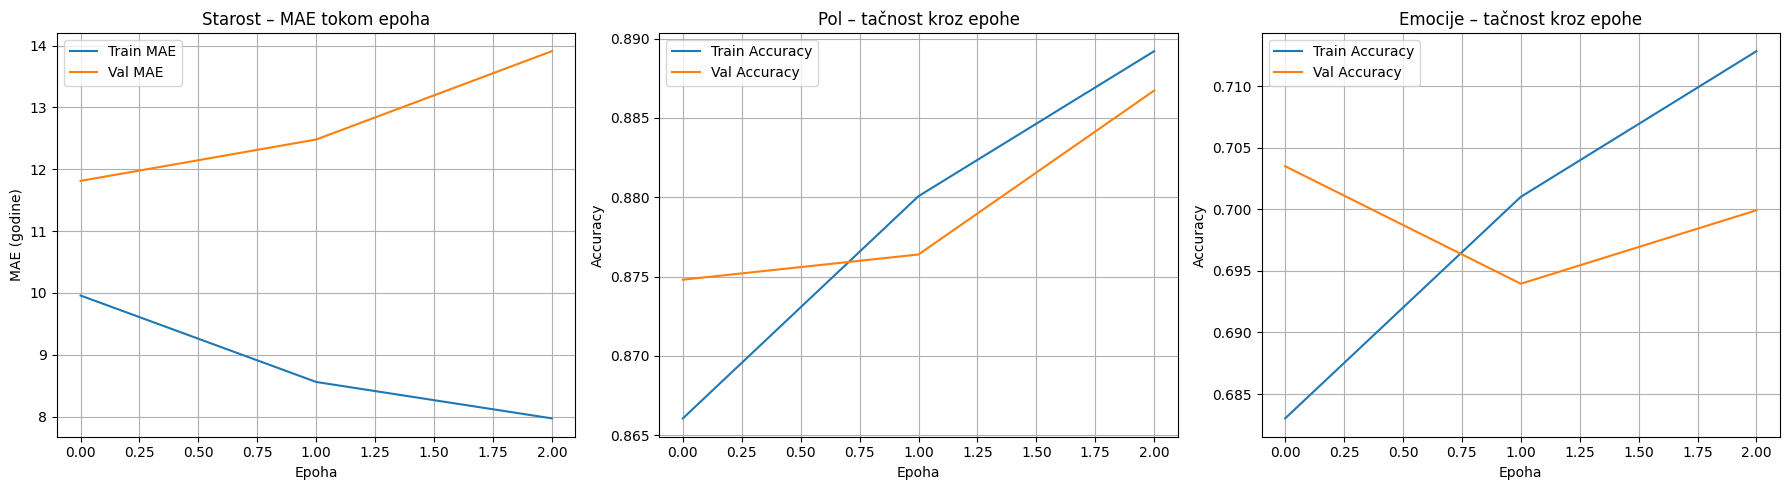

In [ ]:

h = history_final.history

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(h["age_mae"], label="Train MAE")
plt.plot(h["val_age_mae"], label="Val MAE")
plt.title("Starost – MAE tokom epoha")
plt.xlabel("Epoha")
plt.ylabel("MAE (godine)")
plt.legend()
plt.grid(True)

gender_acc_key = None
gender_val_acc_key = None
for key in h.keys():
    if "gender" in key and "acc" in key and not key.startswith("val_"):
        gender_acc_key = key
    if "gender" in key and "acc" in key and key.startswith("val_"):
        gender_val_acc_key = key

plt.subplot(1,3,2)
plt.plot(h[gender_acc_key], label="Train Accuracy")
plt.plot(h[gender_val_acc_key], label="Val Accuracy")
plt.title("Pol – tačnost kroz epohe")
plt.xlabel("Epoha")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

emotion_acc_key = None
emotion_val_acc_key = None
for key in h.keys():
    if "emotion" in key and "acc" in key and not key.startswith("val_"):
        emotion_acc_key = key
    if "emotion" in key and "acc" in key and key.startswith("val_"):
        emotion_val_acc_key = key

plt.subplot(1,3,3)
plt.plot(h[emotion_acc_key], label="Train Accuracy")
plt.plot(h[emotion_val_acc_key], label="Val Accuracy")
plt.title("Emocije – tačnost kroz epohe")
plt.xlabel("Epoha")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 28. Finalna evaluacija

Na kraju merimo ukupnu preciznost modela nad finalnim WIKI test skupom.


79/79 ━━━━━━━━━━━━━━━━━━━━ 75s 952ms/step - age_loss: 12.0835 - age_mae: 12.0836 - emotion_accuracy: 0.7017 - emotion_loss: 0.7922 - gender_accuracy: 0.8720 - gender_loss: 0.3074 - loss: 13.1831
Finalne metrike (WIKI):
age_loss: 11.8071
age_mae: 11.8115
emotion_accuracy: 0.7035
emotion_loss: 0.7999
gender_accuracy: 0.8748
gender_loss: 0.3078
loss: 12.9169


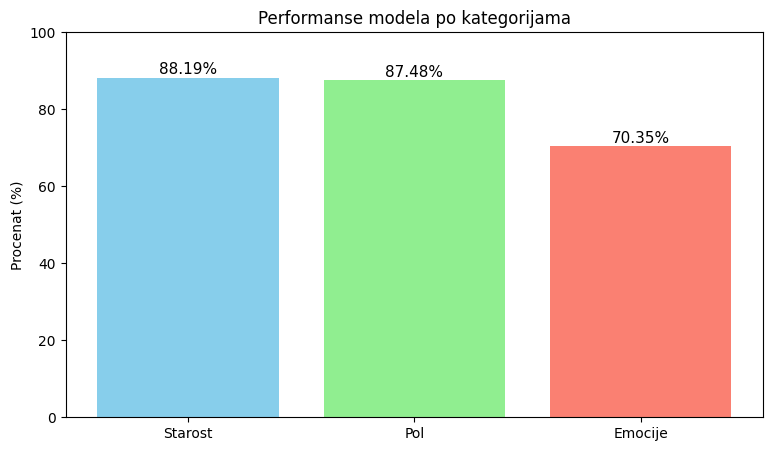

Procena tačnosti za STAROST: 88.19%
Tačnost za EMOCIJE: 70.35%
Tačnost za POL: 87.48%


In [ ]:

results_final = model.evaluate(test_ds_full, return_dict=True)

print("Finalne metrike (WIKI):")
for k, v in results_final.items():
    print(f"{k}: {v:.4f}")

age_mae       = results_final["age_mae"]                 # regresija
gender_acc    = results_final["gender_accuracy"] * 100   # %
emotion_acc   = results_final["emotion_accuracy"] * 100  # %
MAX_AGE = 100
age_score = max(0, 100 - (age_mae / MAX_AGE * 100))

categories = ['Starost', 'Pol', 'Emocije']
scores     = [age_score, gender_acc, emotion_acc]
plt.figure(figsize=(9,5))

bars = plt.bar(categories, scores, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 100)
plt.ylabel('Procenat (%)')
plt.title('Performanse modela po kategorijama')
for i, v in enumerate(scores):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=11)
plt.show()

print(f"Procena tačnosti za STAROST: {age_score:.2f}%")
print(f"Tačnost za EMOCIJE: {emotion_acc:.2f}%")
print(f"Tačnost za POL: {gender_acc:.2f}%")




## Grafik tačnosti

Graf prikazuje kako se **tačnost modela menja tokom treniranja** za svaki od izlaza:

- **Starost (age)** – linije za trening i validaciju prikazuju koliko dobro model procenjuje starost kroz epohe. Pošto je starost regresioni zadatak, MAE je prebačen u vrednosti nalik tačnosti (što je manji MAE, veća „tačnost“).
- **Pol (gender)** – linije za trening i validaciju pokazuju performanse binarne klasifikacije pola.
- **Emocije (emotions)** – linije za trening i validaciju prikazuju tačnost klasifikacije emocija.

Na osnovu ovog grafikona može da se vidi:
- da li model uči (porast tačnosti kroz epohe),
- da li postoji **overfitting** (kada je train tačnost mnogo veća od validation),
- kako se svaki zadatak ponaša u odnosu na ostale (starost, pol, emocije).


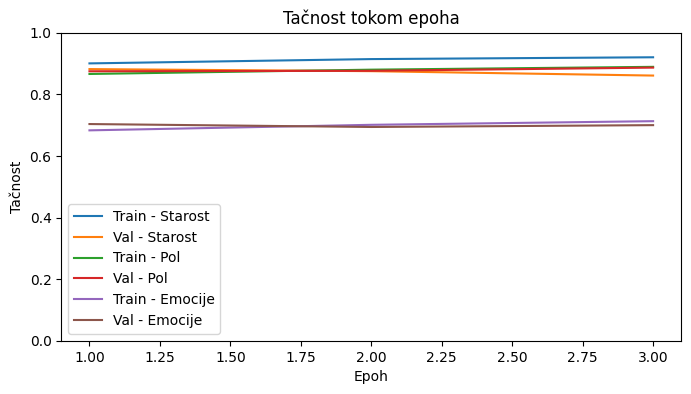

In [ ]:
h = history_final.history
epochs = range(1, len(h["age_mae"]) + 1)
age_acc_train = [1 - v/100 for v in h["age_mae"]]
age_acc_val   = [1 - v/100 for v in h["val_age_mae"]]

plt.figure(figsize=(8,4))

plt.plot(epochs, age_acc_train,      label="Train - Starost")
plt.plot(epochs, age_acc_val,        label="Val - Starost")
plt.plot(epochs, h["gender_accuracy"],      label="Train - Pol")
plt.plot(epochs, h["val_gender_accuracy"],  label="Val - Pol")
plt.plot(epochs, h["emotion_accuracy"],     label="Train - Emocije")
plt.plot(epochs, h["val_emotion_accuracy"], label="Val - Emocije")

plt.title("Tačnost tokom epoha")
plt.xlabel("Epoh")
plt.ylabel("Tačnost")
plt.ylim(0, 1)
plt.legend()
plt.show()


## Grafik gubitka

Graf prikazuje kako se **gubitak (loss) modela menja tokom epoha** za svaki od izlaza:

- **Age loss** – greška procene starosti (što je niža, to je model bolji u proceni godina).
- **Gender loss** – gubitak za binarnu klasifikaciju pola.
- **Emotion loss** – gubitak za višeklasnu klasifikaciju emocija.

Za svaku metriku prikazane su **train** i **validation** krive, što omogućava da se:
- prati da li gubitak opada kroz epohe (napredak modela),
- uoči **overfitting** (kada train loss nastavlja da opada, a validation loss raste),
- uporedi težina pojedinih zadataka (da li je teže naučiti starost, pol ili emocije).

Ovaj graf je dopuna grafiku tačnosti i zajedno daju jasan uvid u ponašanje modela tokom treniranja.


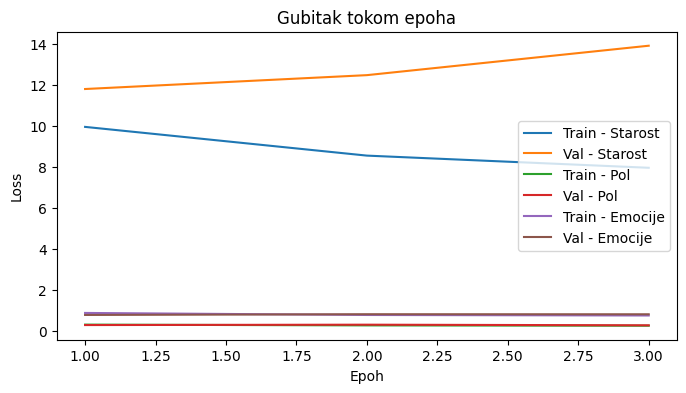

In [ ]:
h = history_final.history
epochs = range(1, len(h["age_loss"]) + 1)

plt.figure(figsize=(8,4))

plt.plot(epochs, h["age_loss"],     label="Train - Starost")
plt.plot(epochs, h["val_age_loss"], label="Val - Starost")
plt.plot(epochs, h["gender_loss"],     label="Train - Pol")
plt.plot(epochs, h["val_gender_loss"], label="Val - Pol")
plt.plot(epochs, h["emotion_loss"],     label="Train - Emocije")
plt.plot(epochs, h["val_emotion_loss"], label="Val - Emocije")

plt.title("Gubitak tokom epoha")
plt.xlabel("Epoha")
plt.ylabel("Loss")
plt.legend()
plt.show()


## 29. Demonstracija rada modela na proizvoljnoj slici

U ovom delu testiramo finalni model na jednoj slici koju korisnik učita sa svog računara.  
normalizacija,
predikcija starosti, pola i emocije,

Na ovaj način proveravamo kako model radi na realnom slučaju.


Saving 142120_tanja-savic-antonio-anhel-ataimages_f.jpg to 142120_tanja-savic-antonio-anhel-ataimages_f (10).jpg
Saving American-actor-Keanu-Reeves-2014.webp to American-actor-Keanu-Reeves-2014 (2).webp


===== Rezultati za sliku: 142120_tanja-savic-antonio-anhel-ataimages_f (10).jpg =====
Starost: 32 godina
Pol: Female (confidence: 96.47%)
Emocija: happy (confidence: 46.17%)



===== Rezultati za sliku: American-actor-Keanu-Reeves-2014 (2).webp =====
Starost: 43 godina
Pol: Male (confidence: 99.38%)
Emocija: sad (confidence: 73.81%)



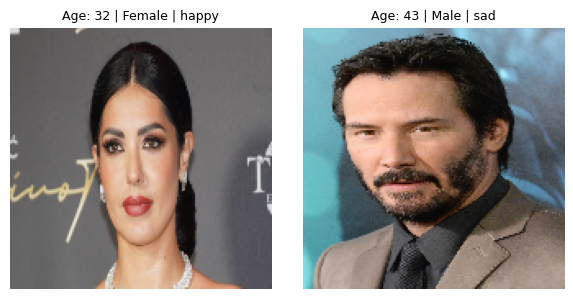

In [ ]:
import cv2
from google.colab import files

uploaded = files.upload()
img_paths = list(uploaded.keys())
if len(img_paths) < 2:
    print("Uploaduj bar dve slike!")
else:
    img_paths = img_paths[:2]
    imgs_resized = []
    batch_tensors = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, IMG_SIZE)  # isti input size
        img_tensor = np.expand_dims(img_resized / 255.0, axis=0)
        imgs_resized.append(img_resized)
        batch_tensors.append(img_tensor)
    batch_input = np.concatenate(batch_tensors, axis=0)
    pred_age_batch, pred_gender_batch, pred_emotion_batch = model.predict(batch_input, verbose=0)
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    for idx, ax in enumerate(axes):
        file_name = img_paths[idx]
        age_val = int(round(pred_age_batch[idx][0]))
        gender_prob = float(pred_gender_batch[idx][0])
        if gender_prob > 0.5:
            gender_val = "Male"
            gender_conf = gender_prob
        else:
            gender_val = "Female"
            gender_conf = 1 - gender_prob
        emo_probs = pred_emotion_batch[idx]
        emotion_id = int(np.argmax(emo_probs))
        emotion_val = emotion_names[emotion_id]
        emotion_conf = float(np.max(emo_probs))
        ax.imshow(imgs_resized[idx])
        ax.axis("off")
        ax.set_title(
            f"Age: {age_val} | {gender_val} | {emotion_val}",
            fontsize=9
        )

        print("\n")
        print(f"===== Rezultati za sliku: {file_name} =====")
        print(f"Starost: {age_val} godina")
        print(f"Pol: {gender_val} (confidence: {gender_conf*100:.2f}%)")
        print(f"Emocija: {emotion_val} (confidence: {emotion_conf*100:.2f}%)\n")

    plt.tight_layout()
    plt.show()



## 30. Zaključak

U ovom projektu razvijen je kompletan **multi-task model za analizu lica**.

Cilj projekta je bio da se sve tri karakteristike obrade i nauče u okviru jednog sistema, uz korišćenje različitih izvora podataka i savremenih tehnika mašinskog učenja.

### Obuhvaćeno u okviru projekta:

#### Obrada IMDB-WIKI dataset-a  
- Pročišćeni su podaci, uklonjene slike sa lošom detekcijom i nerealnim starostima.  
- Formiran je pouzdan skup sa informacijama o starosti i polu.

#### Trening modela za starost i pol  
- Izgrađen je multi-task model zasnovan na MobileNetV2 arhitekturi.  
- U prvoj fazi treniran je na IMDB-WIKI skupu za starost i pol.

####  Obrada FER2013 dataset-a i trening emocija  
- Emocije su naučene isključivo na FER2013 skupu.  
- Primenjeno je mapiranje u multi-head format kako bi model mogao koristiti isti interfejs izlaza.

####  Pseudo-labeling emocija za glavni skup  
- Model treniran na FER skupu je korišćen za predikciju emocija nad IMDB-WIKI slikama.  
- Tako su dobijene “pseudo” emocije koje su dopunile glavni dataset.

####  Finalni multi-task trening  
- Formiran je prošireni IMDB-WIKI dataset (**starost + pol + emocija**).  
- Model je treniran treći put, ali sada nad svim labelama istovremeno.  
- Time je ispunjen uslov projekta da se sva tri zadatka obrađuju nad *istim* glavnim skupom.

####  Evaluacija i vizualizacija  
- Prikazani su grafikoni loss-a, MAE vrednosti i accuracy-ja.  
- Dodatno je urađen confusion matrix za emocije.  
- Rezultati pokazuju stabilno učenje modela i solidnu generalizaciju.

#### Demonstracija modela  
- Učitana je realna slika i model je uspešno dao predikciju starosti, pola i emocije.

Model je uspešno istreniran da objedinjuje tri nezavisna zadatka u jednoj arhitekturi, što je i bio glavni cilj projektnog zadatka.  
Korišćene su savremene tehnike poput transfer learning-a, augmentacije, callback-a i pseudo-labelinga.